Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Applied Modeling, Module 4

- Explain individual predictions with **shapley value plots**

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)


### Three types of model explanations this unit:

#### 1. Global model explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### 3. Individual prediction explanation _(Today)_
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module4')

## Classification: Lending Club 🏦

This notebook uses Lending Club data, historical and current. Predict if peer-to-peer loans are charged off or fully paid. Decide which loans to invest in.

In [2]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv('../data/lending-club/lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv('../data/lending-club/primaryMarketNotes_browseNotes_1-RETAIL.csv')

In [3]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [4]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [5]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [6]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 152)
y_train shape (88334,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [7]:
# Save the ids for later, so we can look up actual results,
# to compare with predicted results
train_id = X_train['id']
val_id = X_val['id']
test_id = X_test['id']

In [8]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [9]:
# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [10]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to numbers
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Reset index
    X = X.reset_index(drop=True)
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [11]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.669638	validation_1-auc:0.672822
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.670802	validation_1-auc:0.674118
[2]	validation_0-auc:0.676142	validation_1-auc:0.680087
[3]	validation_0-auc:0.679771	validation_1-auc:0.683186
[4]	validation_0-auc:0.682482	validation_1-auc:0.684256
[5]	validation_0-auc:0.683905	validation_1-auc:0.685868
[6]	validation_0-auc:0.685104	validation_1-auc:0.687372
[7]	validation_0-auc:0.685857	validation_1-auc:0.687737
[8]	validation_0-auc:0.685805	validation_1-auc:0.687888
[9]	validation_0-auc:0.686504	validation_1-auc:0.689168
[10]	validation_0-auc:0.686866	validation_1-auc:0.689461
[11]	validation_0-auc:0.686938	validation_1-auc:0.689288
[12]	validation_0-auc:0.687537	validation_1-auc:0.69022
[13]	validation_0-auc:0.688371	validation_1-auc:0.690954
[14]	validation_0-auc:0.688811	validation_1-auc:0.691599

[141]	validation_0-auc:0.730186	validation_1-auc:0.719287
[142]	validation_0-auc:0.730303	validation_1-auc:0.719302
[143]	validation_0-auc:0.730414	validation_1-auc:0.719309
[144]	validation_0-auc:0.730559	validation_1-auc:0.71925
[145]	validation_0-auc:0.730765	validation_1-auc:0.719389
[146]	validation_0-auc:0.730859	validation_1-auc:0.719349
[147]	validation_0-auc:0.731034	validation_1-auc:0.719546
[148]	validation_0-auc:0.731146	validation_1-auc:0.719551
[149]	validation_0-auc:0.731293	validation_1-auc:0.719592
[150]	validation_0-auc:0.731476	validation_1-auc:0.7196
[151]	validation_0-auc:0.7317	validation_1-auc:0.719811
[152]	validation_0-auc:0.731873	validation_1-auc:0.719899
[153]	validation_0-auc:0.732035	validation_1-auc:0.719875
[154]	validation_0-auc:0.732108	validation_1-auc:0.71998
[155]	validation_0-auc:0.732179	validation_1-auc:0.719991
[156]	validation_0-auc:0.732222	validation_1-auc:0.719948
[157]	validation_0-auc:0.732292	validation_1-auc:0.719945
[158]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7098250599322629


### Look at predictions vs actuals

In [13]:
df = pd.DataFrame({
    'id': test_id, 
    'pred_proba': y_pred_proba, 
    'status_group': y_test
})

df = df.merge(
     history[['id', 'issue_d', 'sub_grade', 'percent_paid', 'term', 'int_rate']], 
     how='left'
)

In [14]:
df.head()

,id,pred_proba,status_group,issue_d,sub_grade,percent_paid,term,int_rate
0,8626171.0,0.906600,Fully Paid,2013-11-01,B5,1.222841,36 months,13.67%
1,94031368.0,0.751545,Fully Paid,2016-11-01,B5,1.153215,36 months,11.49%
2,5365832.0,0.894157,Fully Paid,2013-05-01,B2,1.178627,36 months,11.14%
3,95806611.0,0.894528,Fully Paid,2017-01-01,A3,1.083891,36 months,7.24%
4,3147498.0,0.959886,Fully Paid,2013-01-01,A3,1.119078,36 months,7.62%


In [15]:
fully_paid = df['status_group'] == 'Fully Paid'
charged_off = ~fully_paid
right = (fully_paid) == (df['pred_proba'] > 0.50)
wrong = ~right

#### Loan was fully paid, model's prediction was right

In [16]:
df[fully_paid & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,percent_paid,term,int_rate
3094,84849701.0,0.742986,Fully Paid,2016-07-01,D2,1.229536,36 months,17.99%
2753,109005992.0,0.753760,Fully Paid,2017-05-01,C1,1.177098,36 months,12.62%
11507,28653578.0,0.802503,Fully Paid,2014-10-01,C1,1.201757,36 months,12.99%
16700,98138268.0,0.813565,Fully Paid,2017-02-01,B2,1.058902,36 months,10.49%
5750,70022639.0,0.829694,Fully Paid,2016-01-01,B5,1.178163,36 months,11.48%
9507,1392481.0,0.836173,Fully Paid,2012-07-01,B4,1.121814,36 months,13.11%
6949,69977048.0,0.896635,Fully Paid,2016-02-01,B3,1.158812,36 months,9.75%
10224,18485719.0,0.912476,Fully Paid,2014-06-01,B4,1.009725,36 months,11.67%
11798,30625900.0,0.947794,Fully Paid,2014-10-01,A1,1.095344,36 months,6.03%
18836,8564969.0,0.964945,Fully Paid,2013-11-01,A3,1.121809,36 months,7.62%


## Explain individual predictions with shapley value plots

#### [Dan Becker explains Shapley Values:](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [17]:
row = X_test.iloc[[3094]]
row

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,...,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim
3094,6.0,GA,36.0,50000.0,NaN,758.0,821.0,77.8,0.0,0.0,...,36 months,18.0,False,248.0,8500.0,45.0,0.0,3700.0,0.0,8500.0


In [18]:
import shap

# processor = pipeline[:-1]

explainer = shap.TreeExplainer(model)
row_process = processor.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

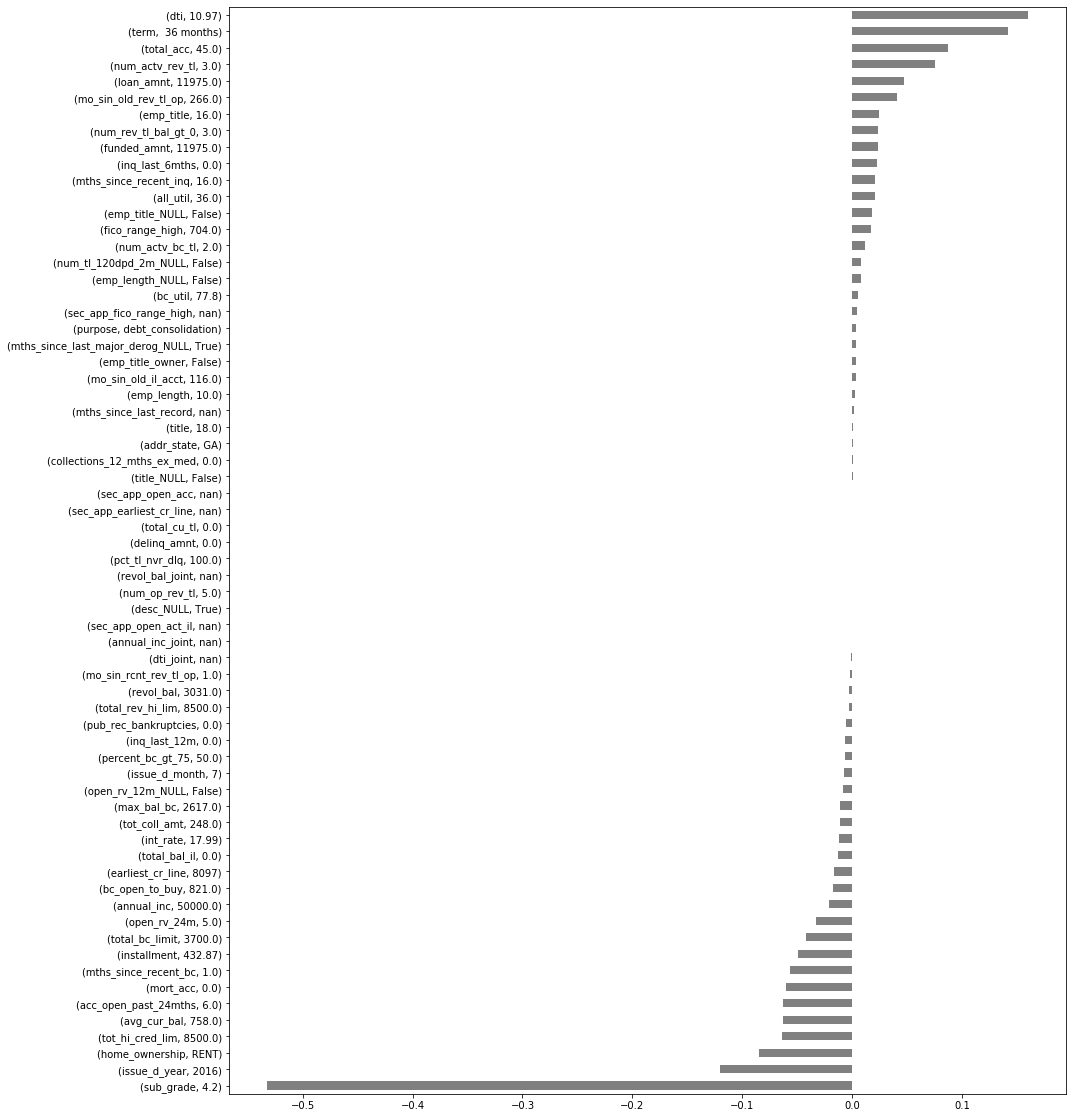

In [19]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names,feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));

In [21]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [22]:
print ('Pros:')

for i, pro in enumerate(pros, start=1):
  # print (pro[0])
  feature_name, feature_value = pro
  print(f'{i}. {feature_name} is {feature_value}')

print ('Cons:')
for i, con in enumerate(cons, start=1):
  # print (pro[0])
  feature_name, feature_value = con
  print(f'{i}. {feature_name} is {feature_value}')

Pros:
1. dti is 10.97
2. term is  36 months
3. total_acc is 45.0
Cons:
1. sub_grade is 4.2
2. issue_d_year is 2016
3. home_ownership is RENT


In [23]:
def explain(row_number):
    positive_class = 'Fully Paid'
    positive_class_index = 1
    
    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)
    
    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba
    
    # Show prediction & probability
    print(f'The model predicts this loan is {pred}, with {pred_proba:.0f}% probability.')
    

    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)
    
    # Get top 3 "pros & cons"
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index
   
    # Show top 3 reasons for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')
    
    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0] 
    print(f'- {feature_name} is {feature_value}.')
    
    
    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row
    )
    
    
explain(3094)

The model predicts this loan is Fully Paid, with 74% probability.


Top 3 reasons for prediction:
1. dti is 10.97.
2. term is  36 months.
3. total_acc is 45.0.


Top counter-argument against prediction:
- sub_grade is 4.2.


## Look at more examples

#### Loan was charged off, model's prediction was right

In [24]:
df[charged_off & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,percent_paid,term,int_rate
15418,123051924.0,0.322159,Charged Off,2017-11-01,D5,0.454244,36 months,21.45%
9788,114179876.0,0.341751,Charged Off,2017-08-01,D4,0.218621,60 months,20.00%
2342,52729162.0,0.410171,Charged Off,2015-06-01,D2,0.407902,60 months,16.55%
13620,134141126.0,0.436343,Charged Off,2018-06-01,D4,0.105713,60 months,20.39%
4818,75164194.0,0.449806,Charged Off,2016-03-01,C2,0.453517,60 months,12.99%
17339,53392378.0,0.466535,Charged Off,2015-07-01,D4,0.465138,60 months,17.57%
854,85633949.0,0.471731,Charged Off,2016-07-01,D2,0.445786,60 months,17.99%
6166,121823115.0,0.477066,Charged Off,2017-10-01,D5,0.316652,60 months,21.45%
8861,79762328.0,0.479116,Charged Off,2016-05-01,D3,0.408118,36 months,18.25%
8383,70853920.0,0.492614,Charged Off,2016-02-01,D2,0.777067,60 months,17.27%


In [25]:
explain(8383)

The model predicts this loan is Charged Off, with 51% probability.


Top 3 reasons for prediction:
1. sub_grade is 4.2.
2. term is  60 months.
3. dti is 26.73.


Top counter-argument against prediction:
- home_ownership is MORTGAGE.


#### Loan was fully paid, model's prediction was wrong

In [26]:
df[fully_paid & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,percent_paid,term,int_rate
11511,67456858.0,0.350205,Fully Paid,2015-12-01,D2,1.185476,60 months,16.55%
8965,113044179.0,0.407605,Fully Paid,2017-07-01,D5,1.289803,36 months,21.45%
12088,56032029.0,0.418064,Fully Paid,2015-08-01,D5,1.423509,60 months,17.86%
11513,143636451.0,0.439329,Fully Paid,2018-11-01,D5,1.049323,60 months,22.35%
15542,78229244.0,0.451555,Fully Paid,2016-05-01,C5,1.331406,60 months,15.31%
17434,57854616.0,0.452163,Fully Paid,2015-09-01,D3,1.006136,60 months,16.99%
18061,42514410.0,0.466100,Fully Paid,2015-03-01,C4,1.350491,60 months,13.99%
9817,40421136.0,0.484455,Fully Paid,2015-02-01,D1,1.434131,60 months,15.59%
15729,113206770.0,0.494287,Fully Paid,2017-07-01,C4,1.132934,36 months,15.05%
12328,85725427.0,0.497500,Fully Paid,2016-07-01,D5,1.362341,36 months,21.49%


In [27]:
explain(18061)

The model predicts this loan is Charged Off, with 53% probability.


Top 3 reasons for prediction:
1. sub_grade is 3.4.
2. term is  60 months.
3. emp_title_NULL is True.


Top counter-argument against prediction:
- dti is 13.04.


#### Loan was charged off, model's prediction was wrong

In [28]:
df[charged_off & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,percent_paid,term,int_rate
4063,97369541.0,0.634287,Charged Off,2017-02-01,B5,0.285203,60 months,11.49%
19876,36201063.0,0.634296,Charged Off,2014-12-01,C5,0.221657,60 months,14.99%
13099,55351888.0,0.684185,Charged Off,2015-07-01,D3,0.465239,60 months,16.99%
17167,1509750.0,0.718808,Charged Off,2012-09-01,C3,0.350589,36 months,15.80%
6066,88946976.0,0.764483,Charged Off,2016-09-01,D2,0.904270,36 months,17.99%
18646,130947315.0,0.776346,Charged Off,2018-04-01,B5,0.181876,60 months,11.98%
2193,46834483.0,0.785439,Charged Off,2015-04-01,C4,0.512837,36 months,13.99%
15554,129035370.0,0.798215,Charged Off,2018-03-01,D5,0.677856,36 months,21.45%
18658,35104264.0,0.811196,Charged Off,2014-11-01,C2,0.413421,36 months,12.99%
19883,63486717.0,0.898776,Charged Off,2015-10-01,B3,0.741487,36 months,9.99%


In [29]:
explain(2193)

The model predicts this loan is Fully Paid, with 79% probability.


Top 3 reasons for prediction:
1. term is  36 months.
2. total_acc is 38.0.
3. home_ownership is OWN.


Top counter-argument against prediction:
- sub_grade is 3.4.


## Regression: NYC Apartment Rents

_**Coming full circle!**_

In [30]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/nyc/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

_**Remember this code you wrote for your first assignment?**_

```python
# Arrange X features matrix & y target vector
features = ['bedrooms', 'bathrooms']
target = 'price'
X = df[features]
y = df[target]

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

def predict(bedrooms, bathrooms):
    y_pred = model.predict([[bedrooms, bathrooms]])
    estimate = y_pred[0]
    bed_coef = model.coef_[0]
    bath_coef = model.coef_[1]
    
    # Format with $ and comma separators. No decimals.
    
    result = f'Rent for a {bedrooms}-bed, {bathrooms}-bath apartment in NYC is estimated at ${estimate:,.0f}.'
    explanation = f' In this model, each bedroom adds ${bed_coef:,.0f} & each bathroom adds ${bath_coef:,.0f}.'
    return result + explanation
```


_**Let's do something similar, but with a tuned Random Forest and Shapley Values.**_

In [31]:
# Assign to X, y
features = ['bedrooms', 'bathrooms', 'longitude', 'latitude']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [32]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.7s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   10.5s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.3s finished


In [33]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 10, 'max_features': 0.5725105617752781, 'n_estimators': 163}
Cross-validation MAE 535.6465811003709


### Define the predict function

In [34]:
def predict(bedrooms, bathrooms, longitude, latitude):
    df = pd.DataFrame(
        data=[[bedrooms, bathrooms, longitude, latitude]], 
        columns=['bedrooms', 'bathrooms', 'longitude', 'latitude']
    )
    pred = model.predict(df)[0]
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)
    
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    
    result = f'Rent is estimated at ${pred:,.0f} for this New York City apartment. \n\n'
    result += f'Starting from a baseline of ${explainer.expected_value:,.0f} \n'
    result += shaps.to_string()
    print(result)
    
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values, 
        features=df
    )

predict(bedrooms=2, bathrooms=1, longitude=-73.97, latitude=40.75)

Rent is estimated at $3,494 for this New York City apartment. 

Starting from a baseline of $3,575 
(bedrooms, 2.0)        105.961057
(bathrooms, 1.0)      -438.821146
(longitude, -73.97)    158.958104
(latitude, 40.75)       92.755536
